In [190]:
# data science
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from matplotlib import figure
import numpy as np
import peakutils, wfdb, pywt
import csv
import statistics
from datetime import datetime
import heartpy as hp

# system imports
import os
import sys

# signal processing
from scipy import signal, stats
from scipy.io import wavfile
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# physionet data
import wfdb
from wfdb import processing

# read json file
import json
%matplotlib notebook

# import neurokit2 as nk

# Read and load data - E4

In [11]:
# read E4 data
#remove the first two rows (start time, sampling frequency)
#add corrected timstamp for each row of data point and store the csv files in dict
def read_E4(filepath, date):
    # HR data -- started 10 seconds later than other metrics
    hr = pd.read_csv(filepath+str('\HR.csv'), header = None)
    # read the start time and sampling frequency; start time is the same for every E4 file
    start_time = hr.values[0]
    hr_samp_rate = hr.values[1]
    # drop the start time and sampling frequency to get time-series data only
    hr = hr.drop(labels = [0, 1], axis = 0, inplace = False)
    # create a index for each row starting at 0
    # then divide the index by the sampling rate and add the timestamp of start time to convert to UNIX time
    hr['Timestamp'] = list(range(0, len(hr),1))
    hr['Timestamp'] = hr['Timestamp'].apply(lambda x: x/hr_samp_rate+start_time)
    hr['Timestamp'] = hr['Timestamp'].str.get(0)
    # convert UNIX time to second (0 second at the start)
    hr['Second'] = hr['Timestamp']
    hr = hr.set_index('Timestamp')
    hr['Second'] = hr['Second'].apply(lambda x: x-hr.index[0])
    hr.columns = ['Heart rate', 'Second']
    
    
    # EDA data
    eda = pd.read_csv(filepath+str('\EDA.csv'), header = None)
    #start_time = eda.values[0]
    eda_samp_rate = eda.values[1]
    eda = eda.drop(labels = [0, 1], axis = 0, inplace = False)
    eda['Timestamp'] = list(range(0, len(eda),1))
    eda['Timestamp'] = eda['Timestamp'].apply(lambda x: x/eda_samp_rate+start_time)
    eda['Timestamp'] = eda['Timestamp'].str.get(0)
    eda['Second'] = eda['Timestamp']
    eda = eda.set_index('Timestamp')
    eda['Second'] = eda['Second'].apply(lambda x: x-eda.index[0])
    eda.columns = ['EDA', 'Second']

    temp = pd.read_csv(filepath+str('\TEMP.csv'), header = None)
    # clean up TEMP file
    #start_time = temp.values[0]
    temp_samp_rate = temp.values[1]
    temp = temp.drop(labels = [0, 1], axis = 0, inplace = False)
    temp['Timestamp'] = list(range(0, len(temp),1))
    temp['Timestamp'] = temp['Timestamp'].apply(lambda x: x/temp_samp_rate+start_time)
    temp['Timestamp'] = temp['Timestamp'].str.get(0)
    temp['Second'] = temp['Timestamp']
    temp = temp.set_index('Timestamp')
    temp['Second'] = temp['Second'].apply(lambda x: x-temp.index[0])
    temp.columns = ['Temp', 'Second']
    
    ibi = pd.read_csv(filepath+str('\IBI.csv'), header = None) # no correction of timestamp needed
    ibi = ibi.drop(labels = [0, 1], axis = 0, inplace = False)
    ibi.columns = ['Second', 'IBI']
    
    bvp = pd.read_csv(filepath+str('\BVP.csv'), header = None)
    #start_time = bvp.values[0]
    bvp_samp_rate = bvp.values[1]
    bvp = bvp.drop(labels = [0, 1], axis = 0, inplace = False)
    bvp['Timestamp'] = list(range(0, len(bvp),1))
    bvp['Timestamp'] = bvp['Timestamp'].apply(lambda x: np.round(x/bvp_samp_rate+start_time, 2))
    bvp['Timestamp'] = bvp['Timestamp'].str.get(0)
    bvp['Second'] = bvp['Timestamp']
    bvp = bvp.set_index('Timestamp')
    bvp['Second'] = bvp['Second'].apply(lambda x: x-bvp.index[0])
    bvp.columns = ['BVP', 'Second']
    
    data_dict = {'Date':date, 'HR':hr, 'EDA':eda, 'TEMP':temp, 'IBI':ibi, 'BVP':bvp}
    return data_dict 

In [12]:
# read the file path of participant's E4 file
filepath_p14 = r'C:\Users\maoyuan2\Documents\RADWear Stress Detection data analysis\P14_data\A036EE_220620-224412'
# read the date of collected data
date_p14 = filepath_p14[-13:-7]
# extract all data (HR, BVP, EDA, Temp) from the files
data_p14 = read_E4(filepath_p14, date_p14)
tags = pd.read_csv(filepath_p14+str('\\tags.csv'), header = None) # sampled at 64 Hz
tags = tags[0].values.tolist()

In [13]:
pd.options.display.float_format = '{:.2f}'.format
bvp_p14 = data_p14['BVP']
bvp_p14 = bvp_p14.reset_index()
# tagged events and corresponding BVP values and seconds
tags_info = bvp_p14.loc[bvp_p14['Timestamp'].isin(tags)]

In [72]:
t0_bvp = bvp_p14['Timestamp'][0]

### Data visualization

In [14]:
#plot as subfigures
def plot_raw_e4(e4_data, tags_info):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
    ax1.plot(e4_data['BVP']['Second'], e4_data['BVP']['BVP'])
    ax1.set_ylabel('BVP')
    ax1.set_title('Empatica E4 raw data')

    ax2.plot(e4_data['HR']['Second'], e4_data['HR']['Heart rate'])
    ax2.set_ylabel('HR (bpm)')

    ax3.plot(e4_data['TEMP']['Second'], e4_data['TEMP']['Temp'])
    ax3.set_ylabel("Body Temp ($^\circ$C)")

    ax4.plot(e4_data['EDA']['Second'], e4_data['EDA']['EDA'])
    ax4.set_ylabel('EDA (\u03BCS)')
    ax4.set_xlabel('Time (s)')
    for i in range(tags_info.shape[0]):
        ax1.axvline(x = tags_info['Second'].values[i], color = 'red', label = 'axvline - full height')
        ax2.axvline(x = tags_info['Second'].values[i], color = 'red', label = 'axvline - full height')
        ax3.axvline(x = tags_info['Second'].values[i], color = 'red', label = 'axvline - full height')
        ax4.axvline(x = tags_info['Second'].values[i], color = 'red', label = 'axvline - full height')
    

In [306]:
bvp_p14['Second'][sampfrom:sampto]

1000      15.62
1001      15.64
1002      15.66
1003      15.67
1004      15.69
          ...  
79995   1249.92
79996   1249.94
79997   1249.95
79998   1249.97
79999   1249.98
Name: Second, Length: 79000, dtype: float64

<IPython.core.display.Javascript object>


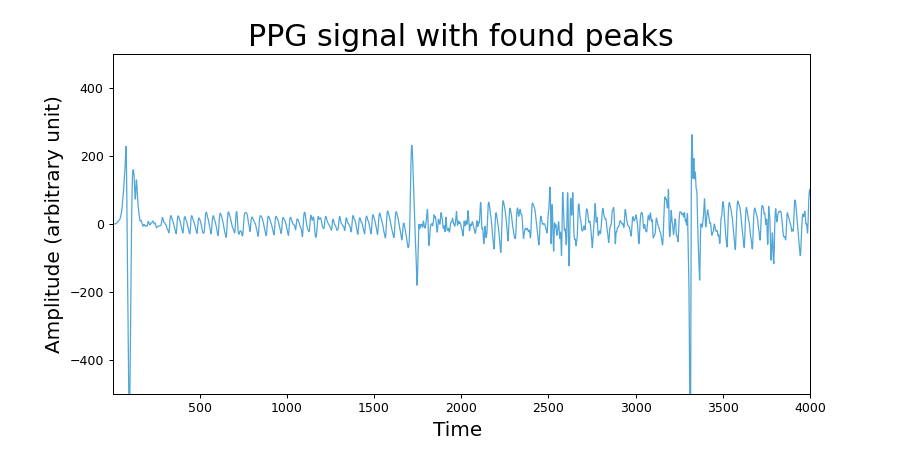

<IPython.core.display.Javascript object>


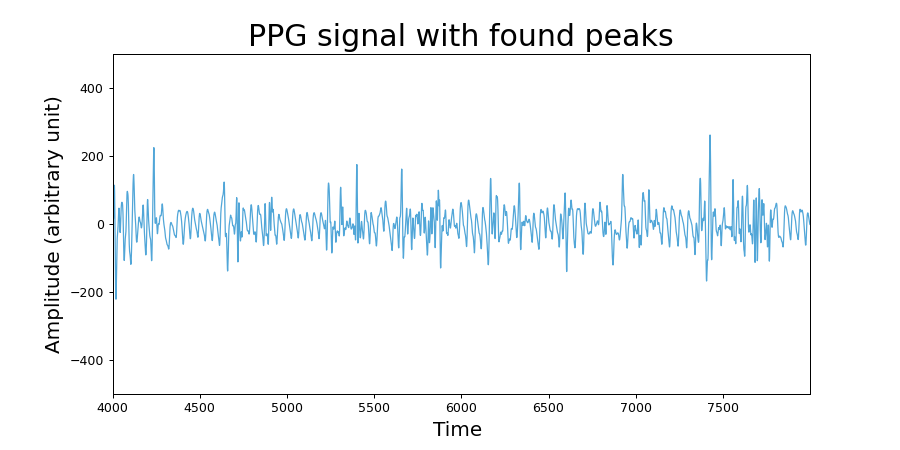

<IPython.core.display.Javascript object>


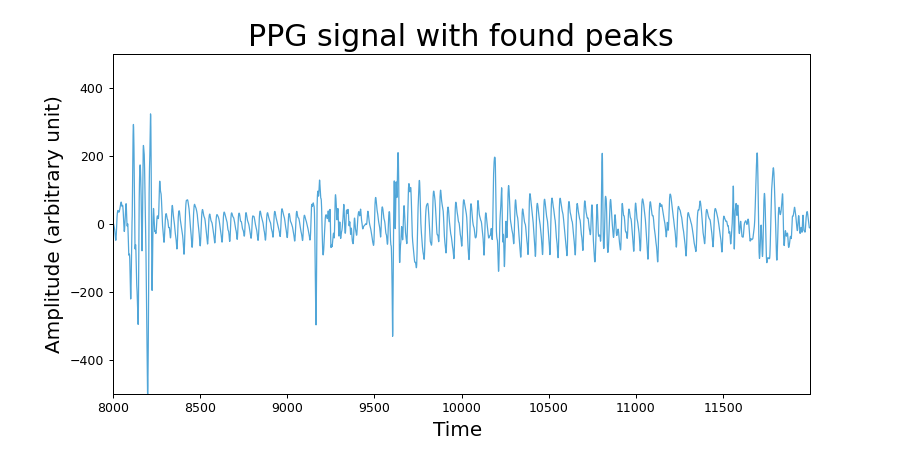

<IPython.core.display.Javascript object>


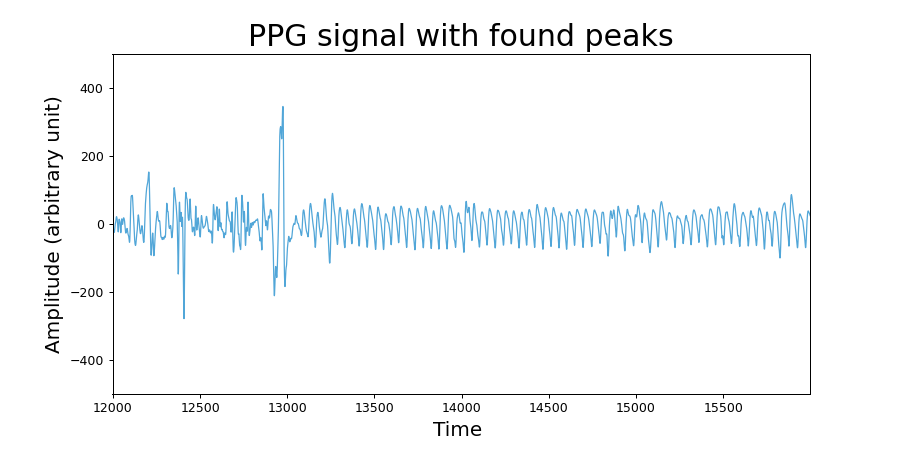

<IPython.core.display.Javascript object>


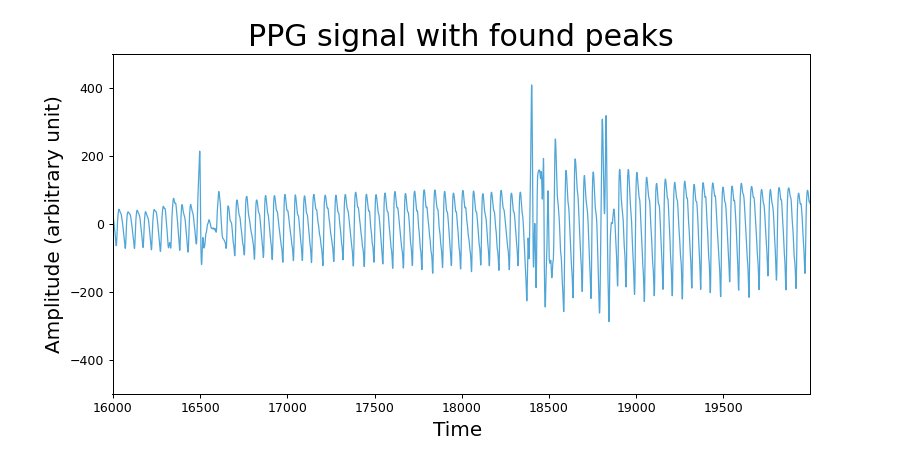

<IPython.core.display.Javascript object>


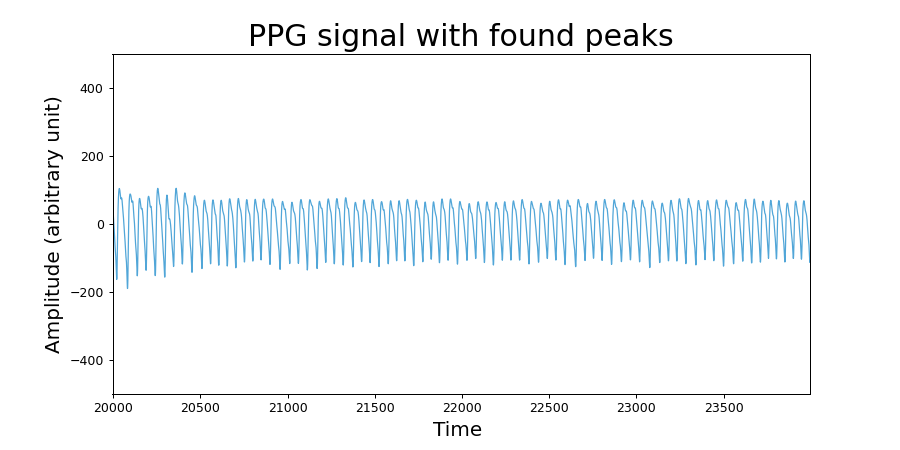

<IPython.core.display.Javascript object>


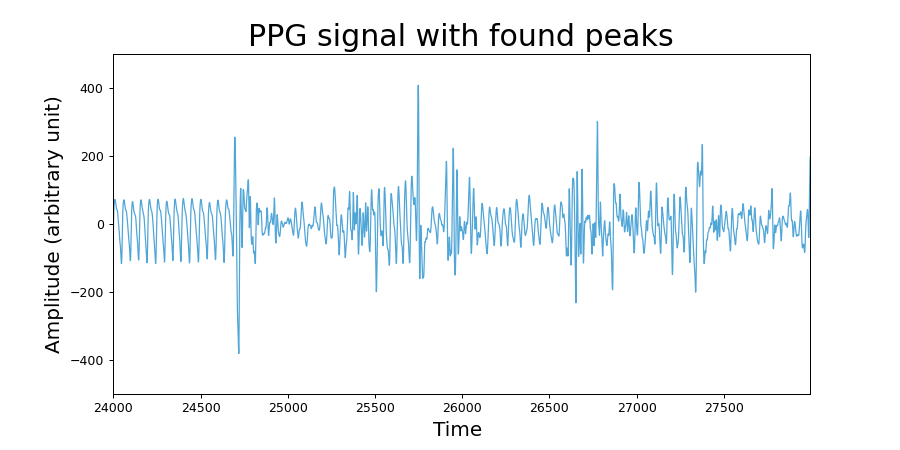

<IPython.core.display.Javascript object>


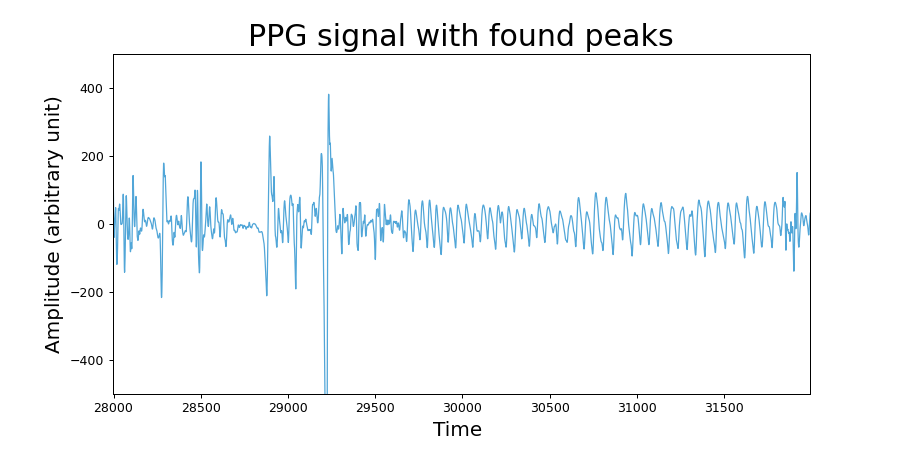

<IPython.core.display.Javascript object>


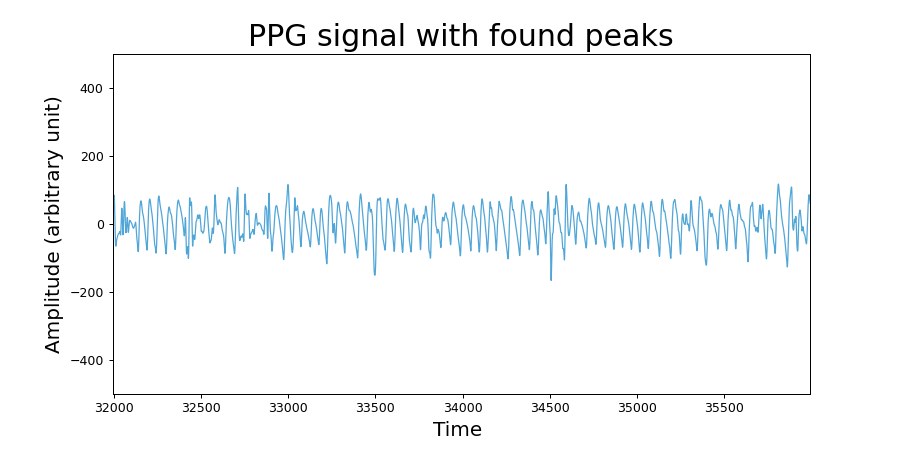

<IPython.core.display.Javascript object>


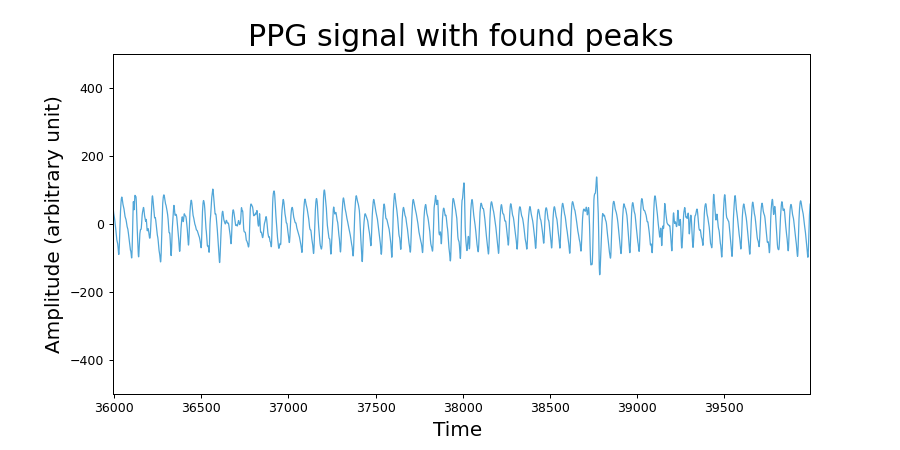

<IPython.core.display.Javascript object>


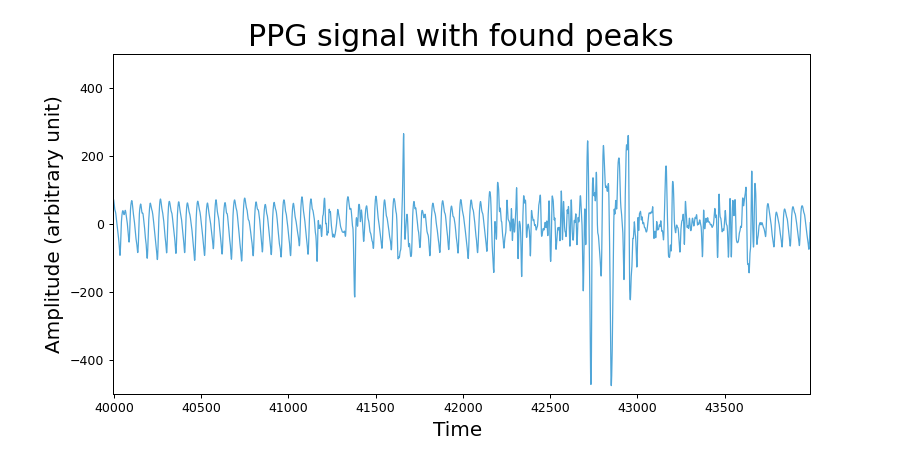

<IPython.core.display.Javascript object>


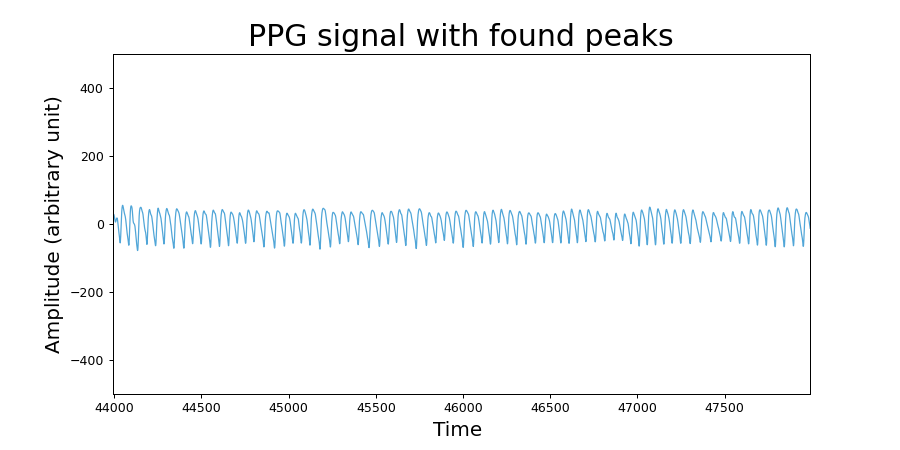

<IPython.core.display.Javascript object>


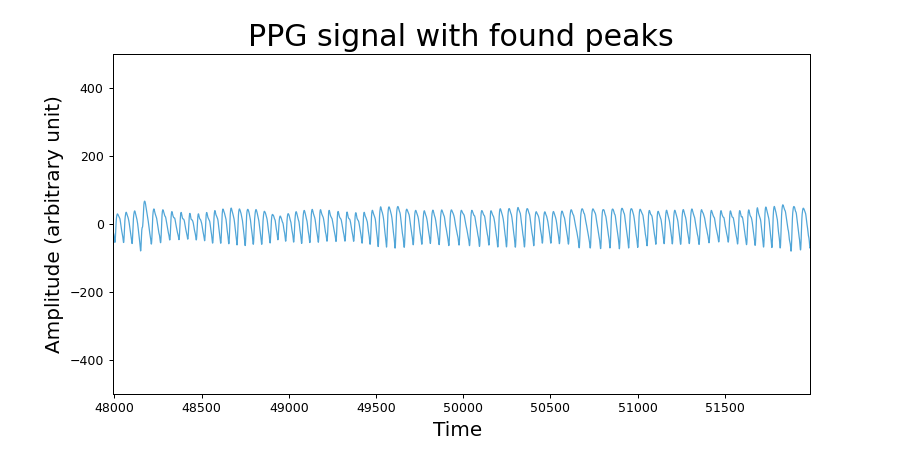

<IPython.core.display.Javascript object>


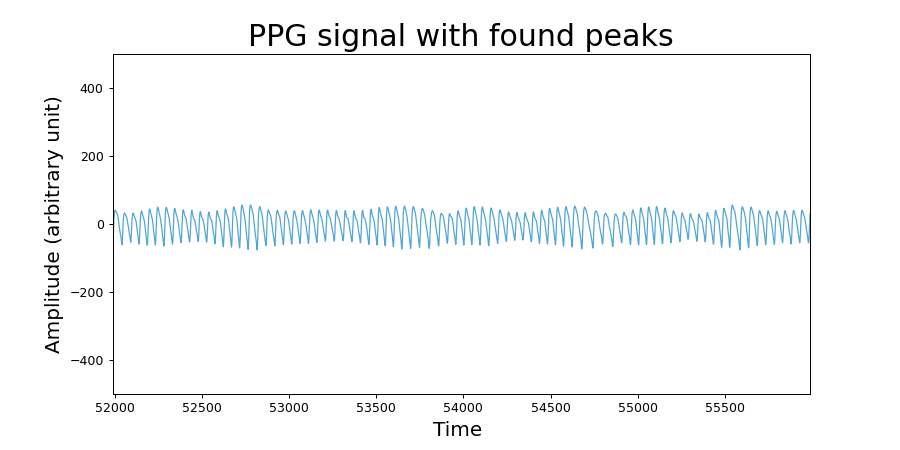

<IPython.core.display.Javascript object>


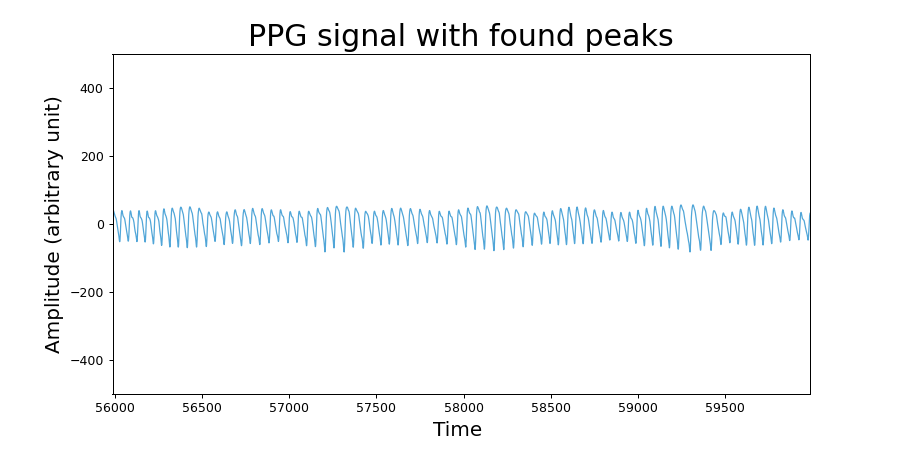

<IPython.core.display.Javascript object>


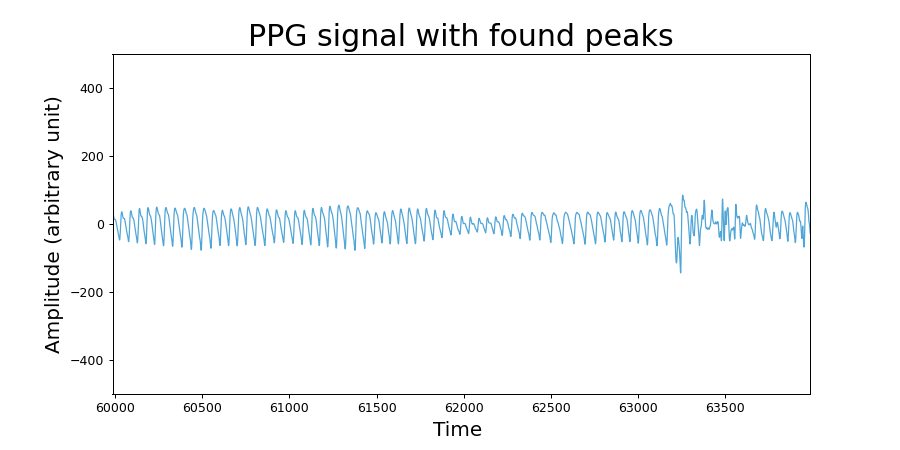

<IPython.core.display.Javascript object>


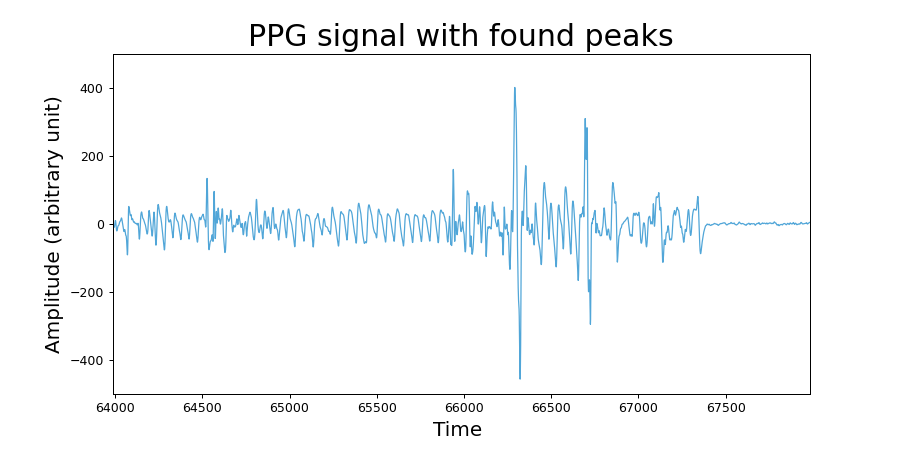

<IPython.core.display.Javascript object>


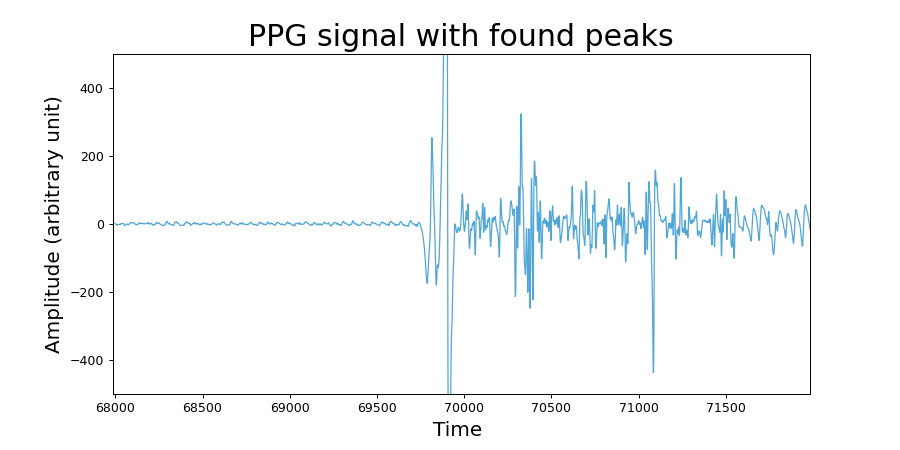

<IPython.core.display.Javascript object>


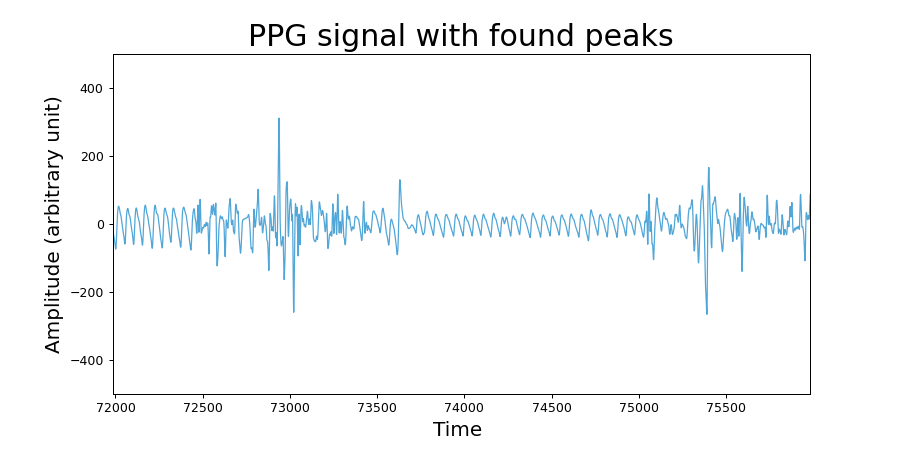

<IPython.core.display.Javascript object>


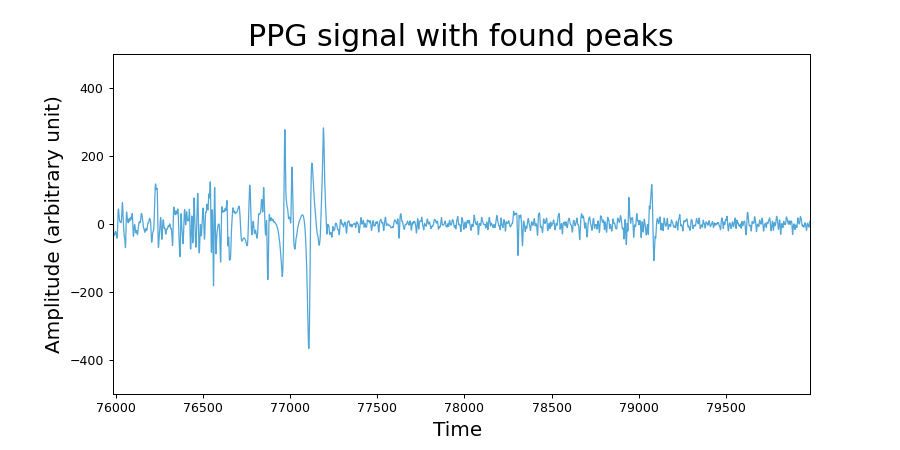

<IPython.core.display.Javascript object>


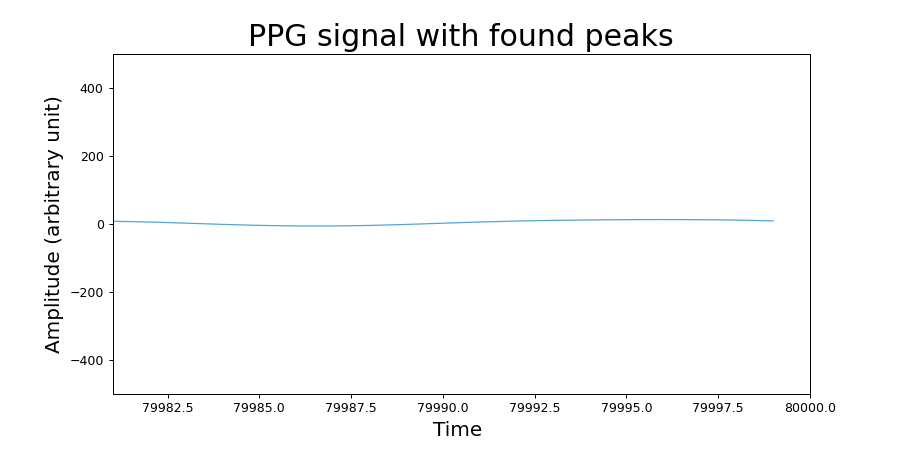

In [329]:
sampfrom = 1
sampto = 80000
nr_plots = 20

bvp_slice = bvp_p14['BVP'][sampfrom:sampto]

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of PPG data
    
    # plot similarity
    plt.figure(figsize=(10, 5))
    plt.title("PPG signal with found peaks", fontsize=24)
    plt.plot(bvp_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.xlabel("Time ", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    
    #ax2 = plt.gca().twinx()
    #ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    plt.xlim(start, stop)
    plt.ylim(-500, 500)

In [325]:
ecg

Timestamp   ECG  Second
0      1655765484.86 12.67    0.00
1      1655765484.86 18.94    0.00
2      1655765484.86 20.95    0.01
3      1655765484.87 21.24    0.01
4      1655765484.87 20.81    0.02
...              ...   ...     ...
203211 1655766278.65  8.50  793.79
203212 1655766278.65  8.50  793.80
203213 1655766278.66  8.50  793.80
203214 1655766278.66  8.51  793.80
203215 1655766278.66  8.50  793.81

[203216 rows x 3 columns]

In [326]:
bvp_p14

Timestamp   BVP  Second
0     1655765062.00 -0.00    0.00
1     1655765062.02 -0.00    0.02
2     1655765062.03 -0.00    0.03
3     1655765062.05 -0.00    0.05
4     1655765062.06 -0.00    0.06
...             ...   ...     ...
85289 1655766394.64 21.55 1332.64
85290 1655766394.66 17.78 1332.66
85291 1655766394.67 14.26 1332.67
85292 1655766394.69 10.98 1332.69
85293 1655766394.70  7.93 1332.70

[85294 rows x 3 columns]

# Read and load data - Hexoskin

In [62]:
raw_ECG = wavfile.read(r'C:\Users\maoyuan2\Downloads\record-247555\record_247555\ECG_I.wav') 
settings = {}
settings['fs'] = 256 # sampling rate
raw_ECG = pd.DataFrame(data = raw_ECG[1])
ecg = 0.0064 * raw_ECG #get correct magnitude of ECG
ecg.rename(columns = {0: 'ECG'}, inplace = True)
# Opening JSON file and return it as dictionary
f = open(r'C:\Users\maoyuan2\Downloads\record-247555\record_247555\info.json')
date_info = json.load(f)

In [48]:
ecg

ECG
0      12.67
1      18.94
2      20.95
3      21.24
4      20.81
...      ...
203211  8.50
203212  8.50
203213  8.50
203214  8.51
203215  8.50

[203216 rows x 1 columns]

### Add timestamp to ECG signal

In [70]:
t0_ecg = list(date_info.values())[0]/256
ecg['Timestamp'] = list(range(0, len(raw_ECG),1))
ecg['Timestamp'] = ecg['Timestamp'].apply(lambda x: x/256+t0_ecg)
#ecg['Timestamp'] = ecg['Timestamp'].str.get(0)
ecg['Second'] = ecg['Timestamp']
ecg = ecg.set_index('Timestamp')
ecg['Second'] = ecg['Second'].apply(lambda x: x-ecg.index[0])
ecg = ecg.reset_index()
#ecg.columns = ['Heart rate', 'Second']

In [67]:
ecg

Timestamp   ECG  Second
0      1655765484.86 12.67    0.00
1      1655765484.86 18.94    0.00
2      1655765484.86 20.95    0.01
3      1655765484.87 21.24    0.01
4      1655765484.87 20.81    0.02
...              ...   ...     ...
203211 1655766278.65  8.50  793.79
203212 1655766278.65  8.50  793.80
203213 1655766278.66  8.50  793.80
203214 1655766278.66  8.51  793.80
203215 1655766278.66  8.50  793.81

[203216 rows x 3 columns]

### Helper functions

In [285]:
def get_plot_ranges(start, end, n):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [19]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

In [20]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation

    similarity = np.correlate(np.ravel(ecg_signal), qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

### Data visualization

<IPython.core.display.Javascript object>


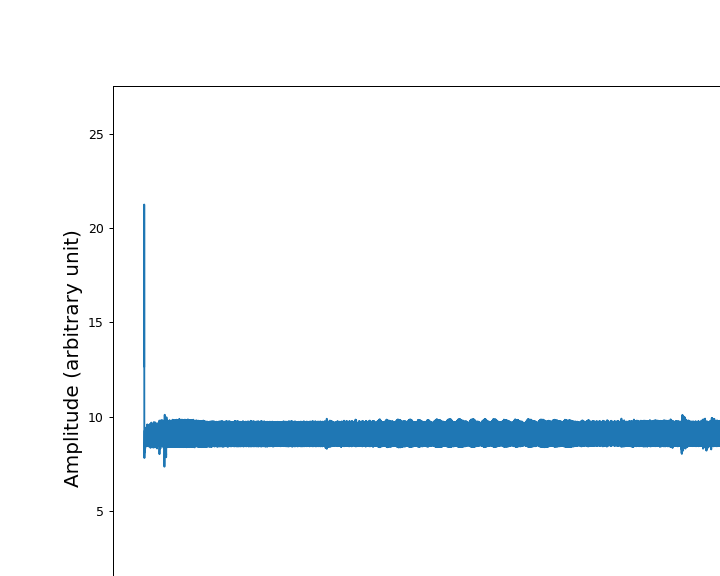

Text(0, 0.5, 'Amplitude (arbitrary unit)')

In [261]:
plt.figure(figsize=(10, 8))
#start = 70000
#stop = 100000
#duration = (stop-start) / settings['fs']
#plt.title("ECG signal, slice of %.1f seconds" % duration, fontsize=24)
plt.plot(ecg.ECG)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

<IPython.core.display.Javascript object>


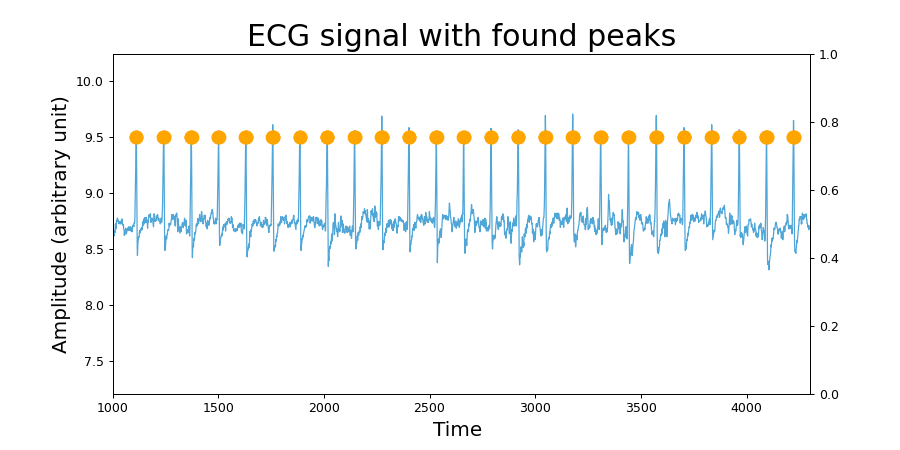

<IPython.core.display.Javascript object>


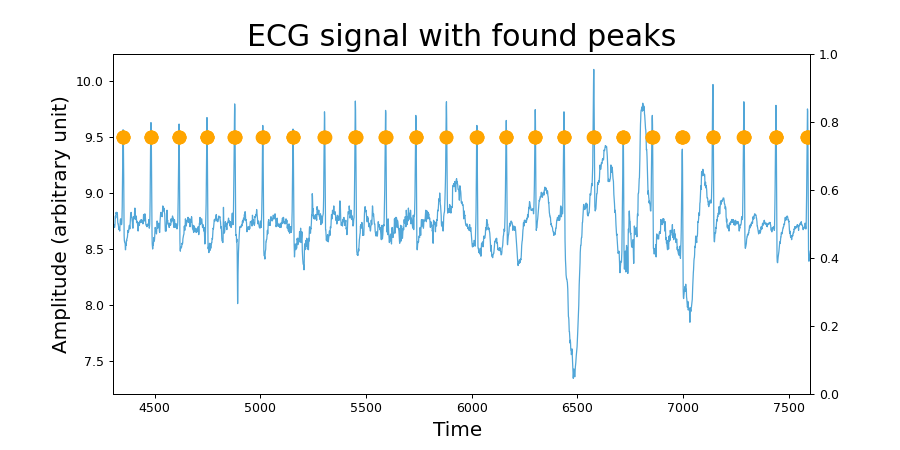

<IPython.core.display.Javascript object>


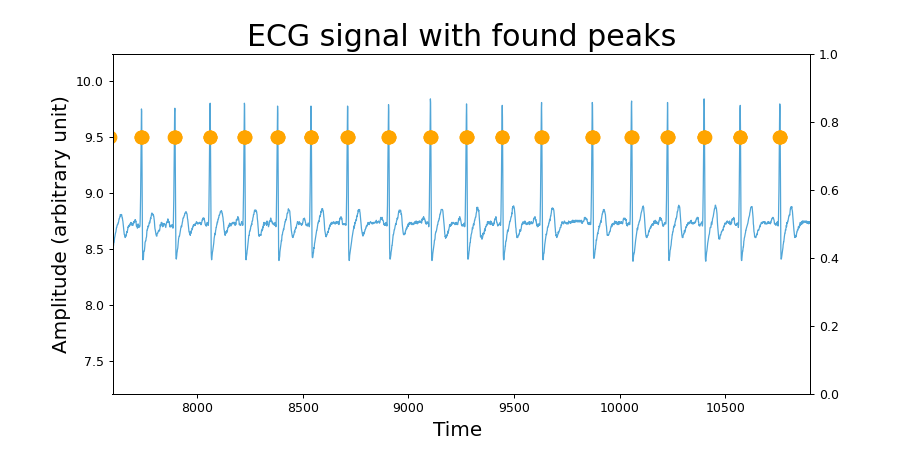

<IPython.core.display.Javascript object>


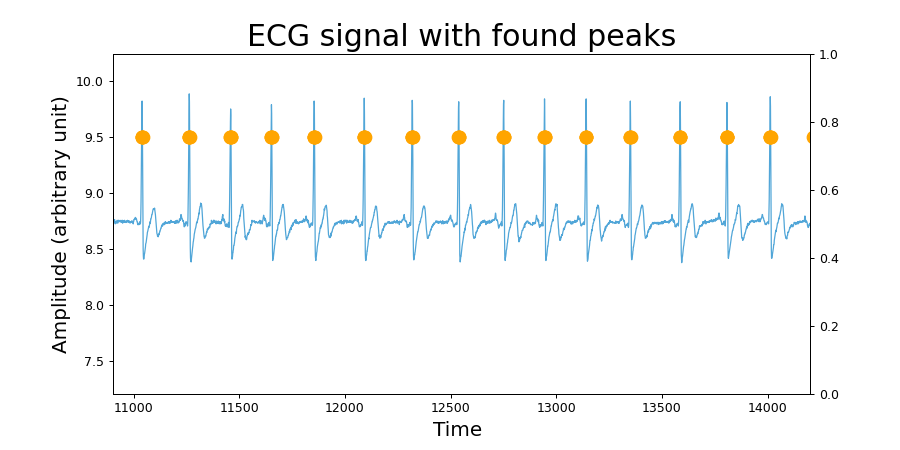

<IPython.core.display.Javascript object>


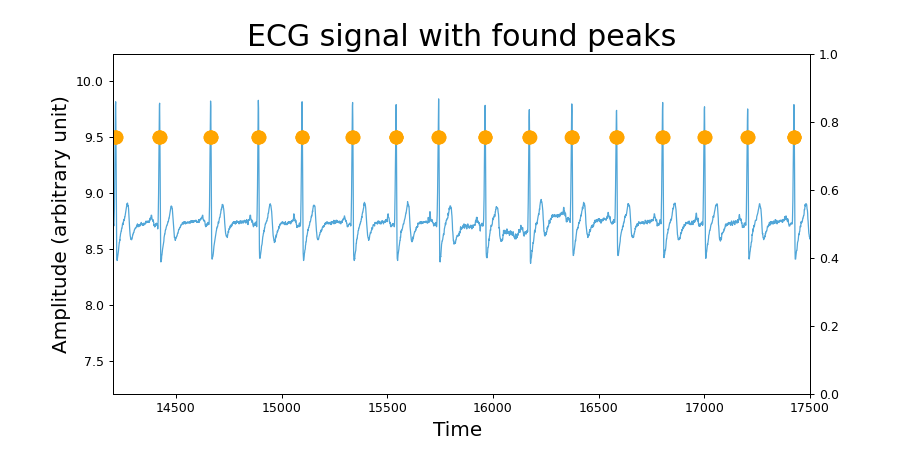

<IPython.core.display.Javascript object>


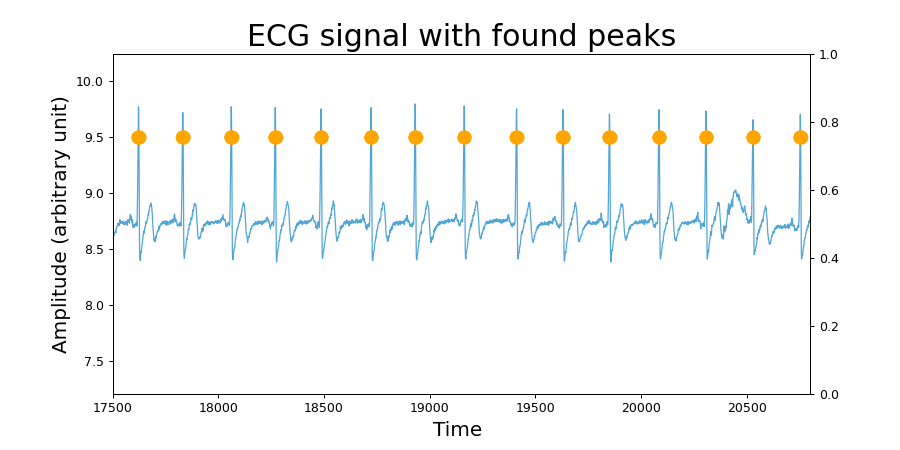

<IPython.core.display.Javascript object>


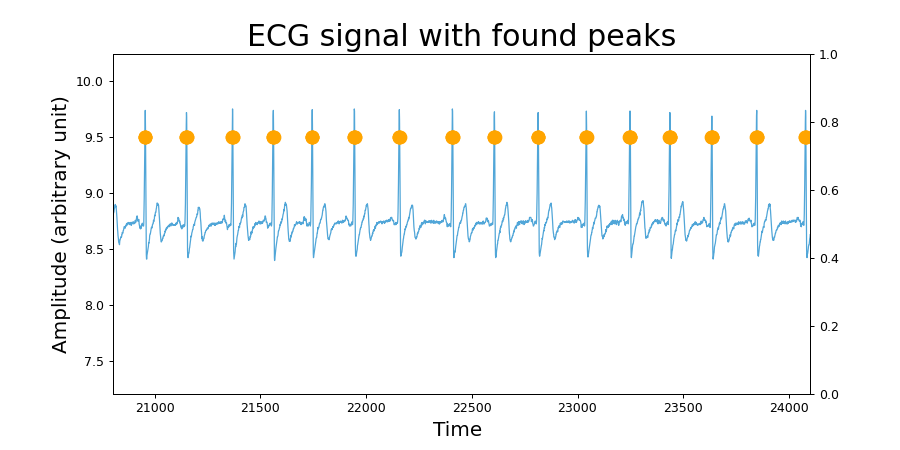

<IPython.core.display.Javascript object>


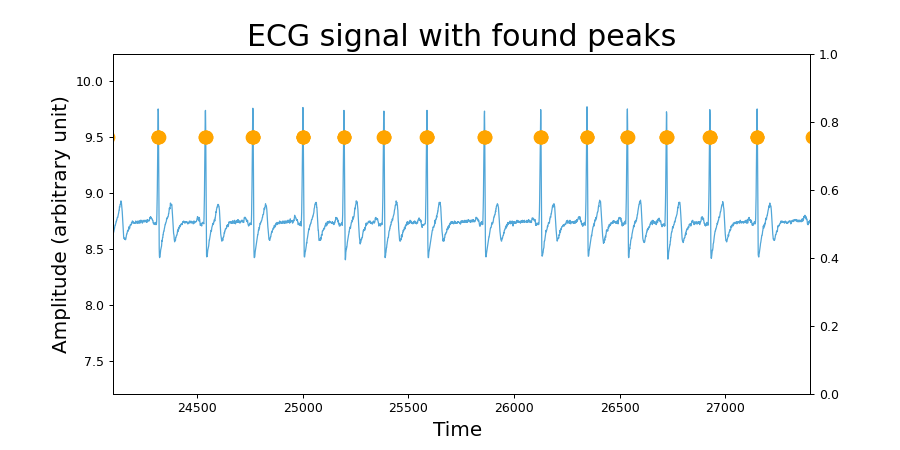

C:\Users\maoyuan2\AppData\Local\Temp/ipykernel_15292/761887749.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 5))


<IPython.core.display.Javascript object>


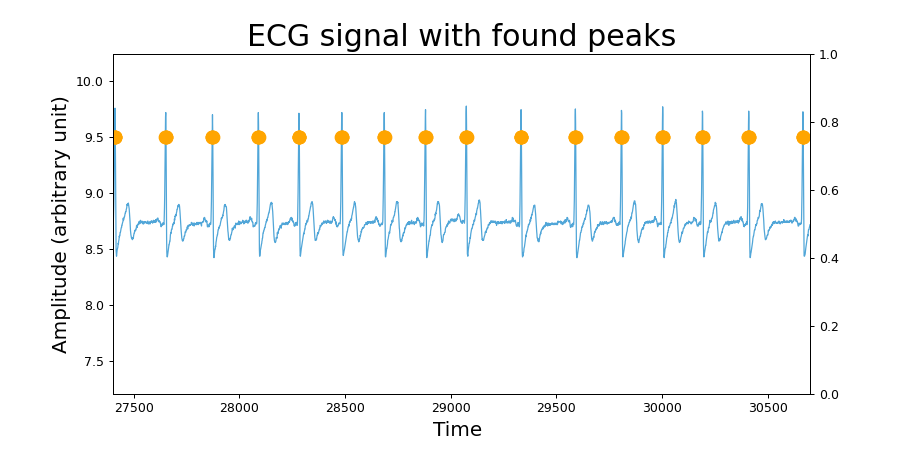

<IPython.core.display.Javascript object>


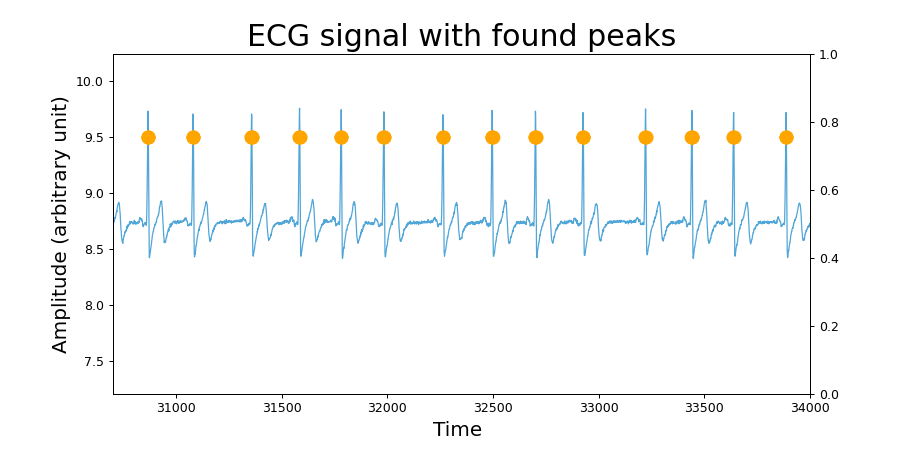

<IPython.core.display.Javascript object>


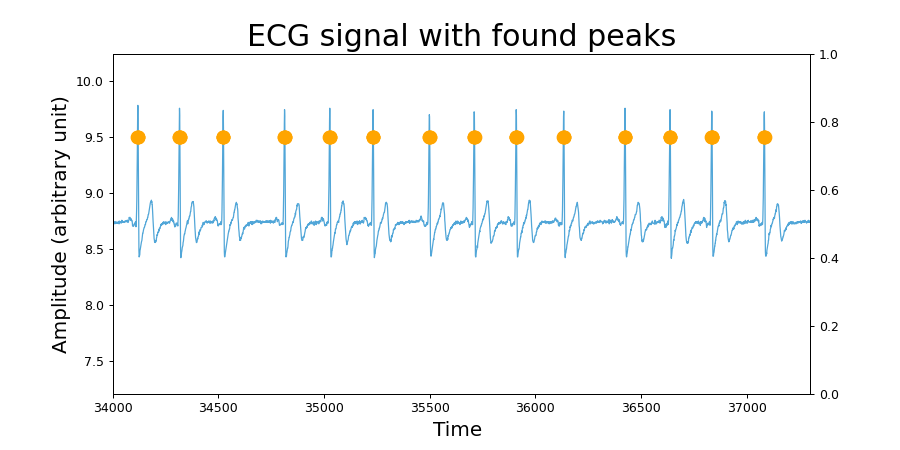

<IPython.core.display.Javascript object>


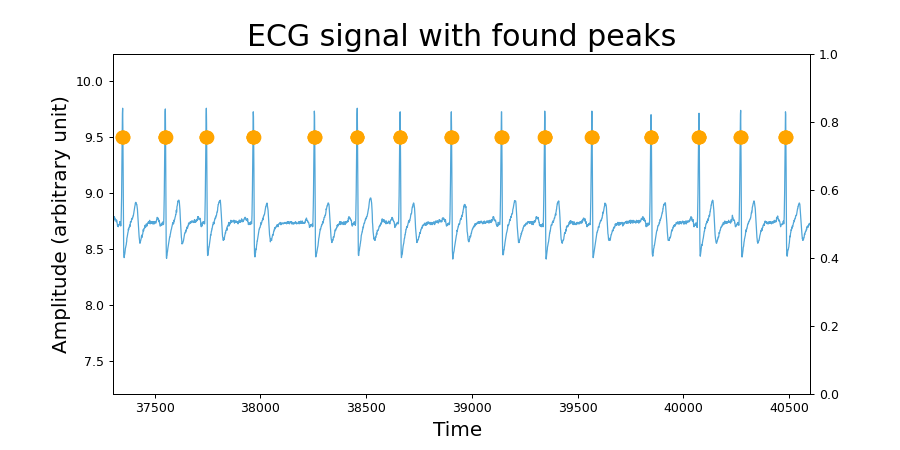

<IPython.core.display.Javascript object>


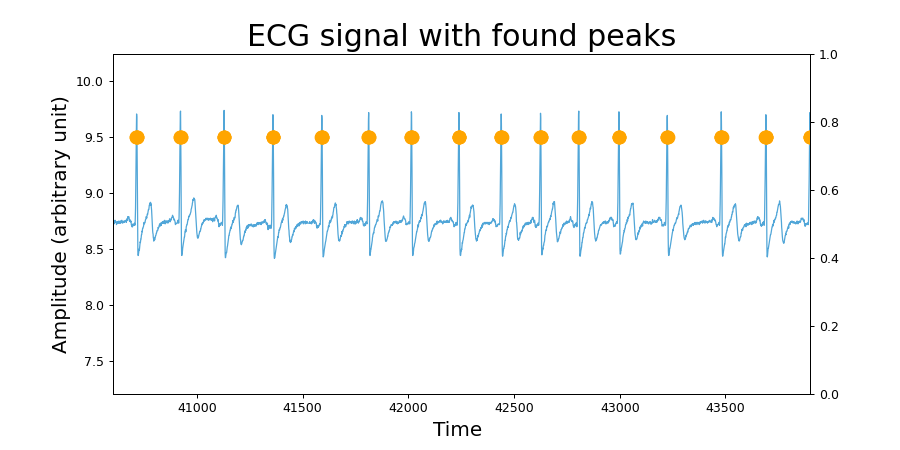

<IPython.core.display.Javascript object>


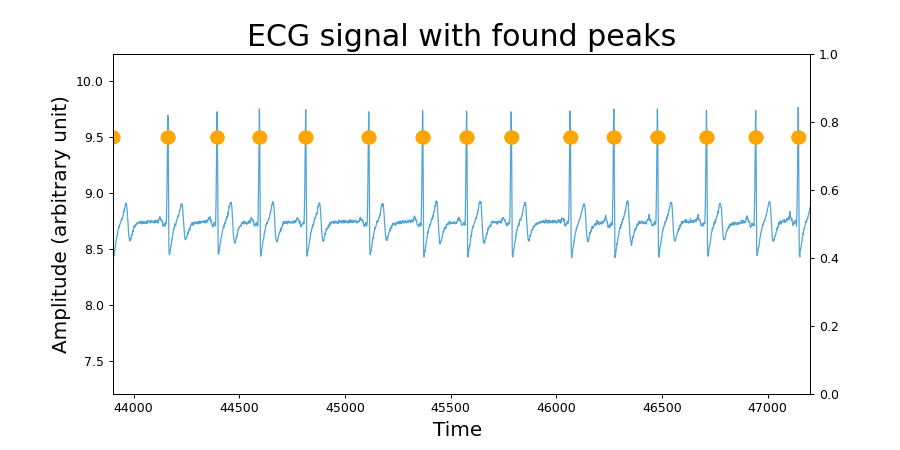

<IPython.core.display.Javascript object>


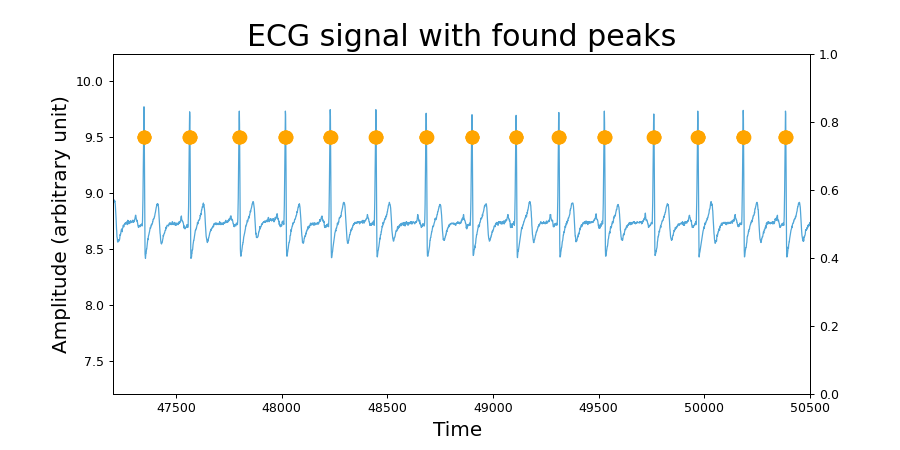

<IPython.core.display.Javascript object>


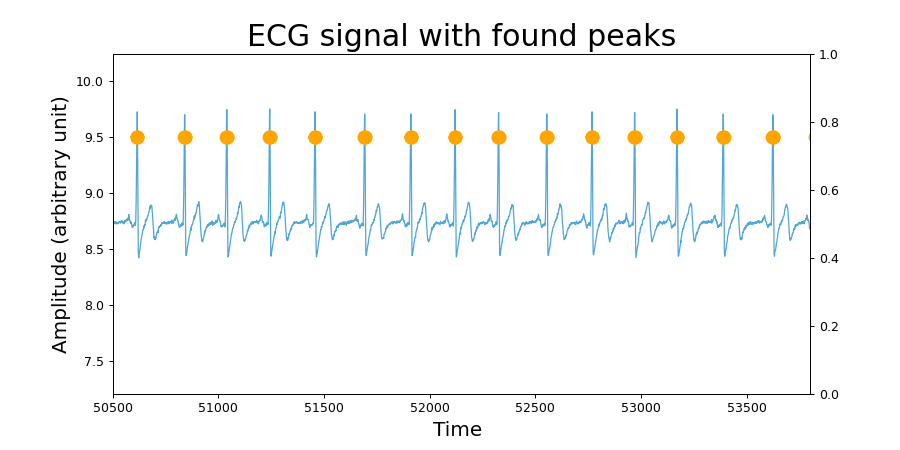

<IPython.core.display.Javascript object>


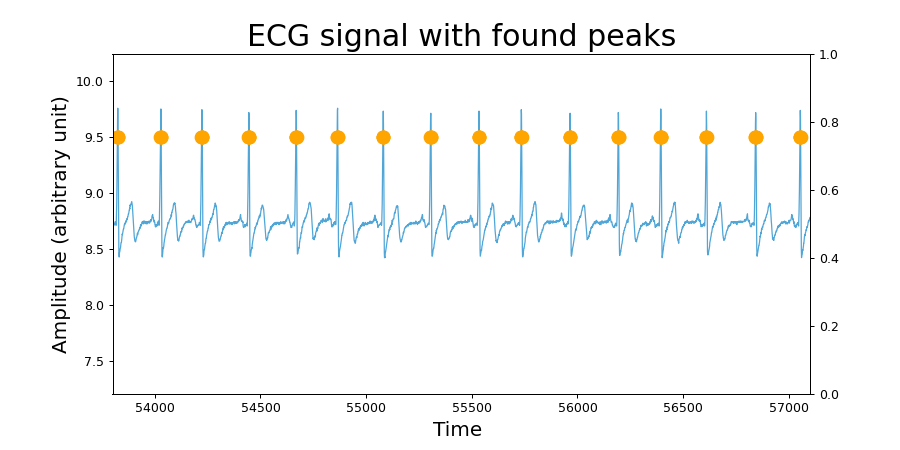

<IPython.core.display.Javascript object>


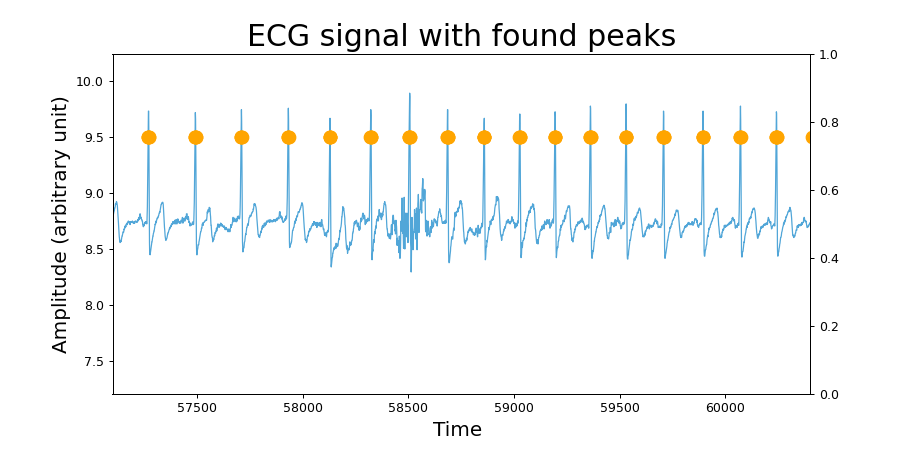

<IPython.core.display.Javascript object>


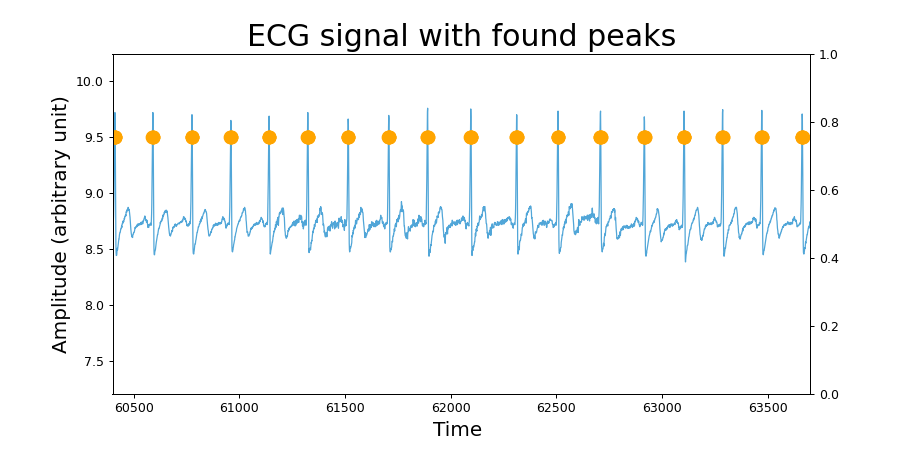

<IPython.core.display.Javascript object>


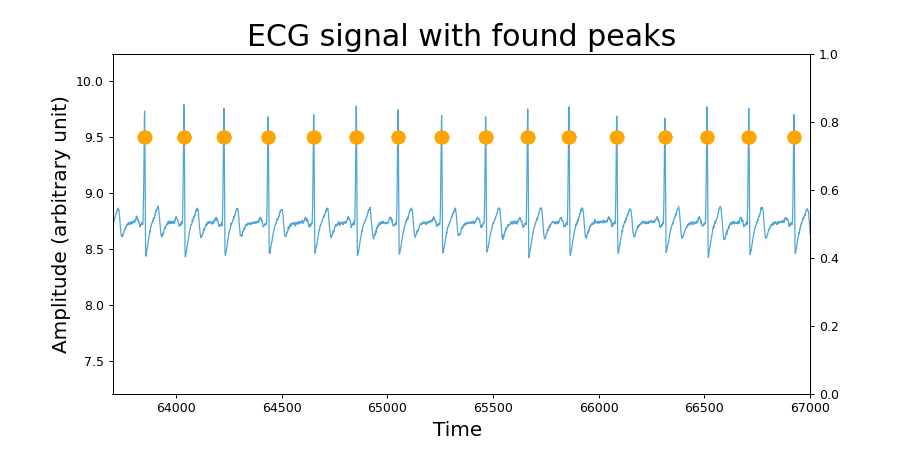

<IPython.core.display.Javascript object>


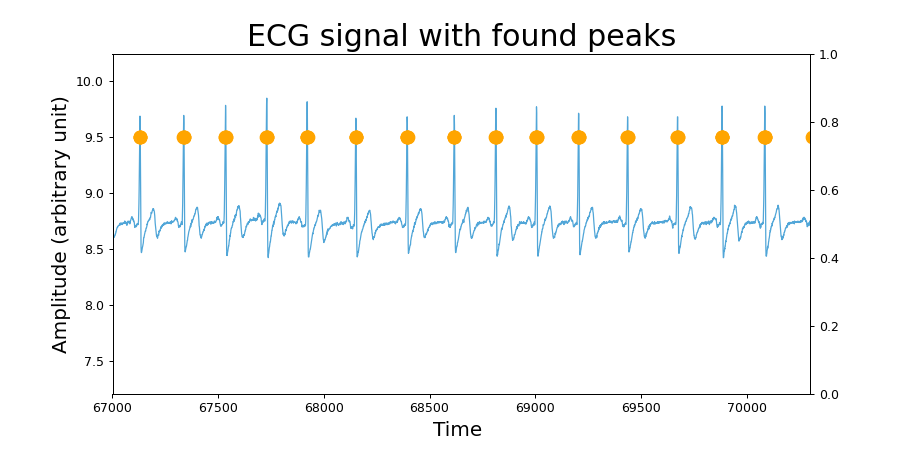

<IPython.core.display.Javascript object>


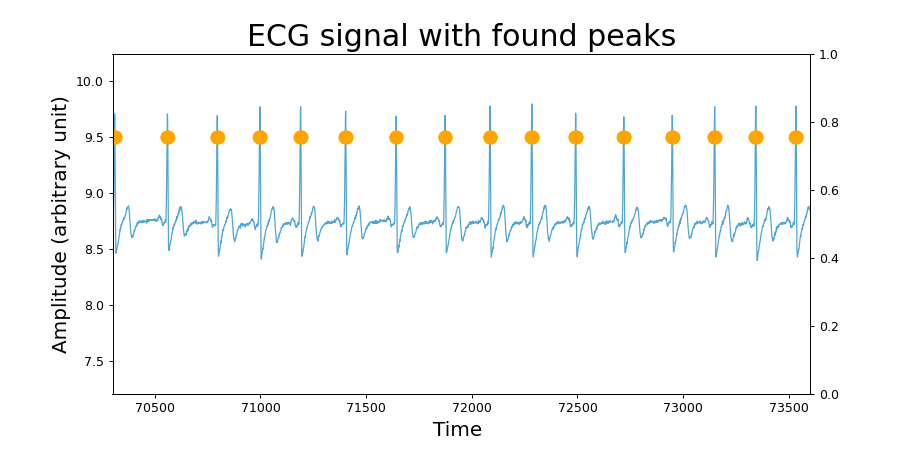

<IPython.core.display.Javascript object>


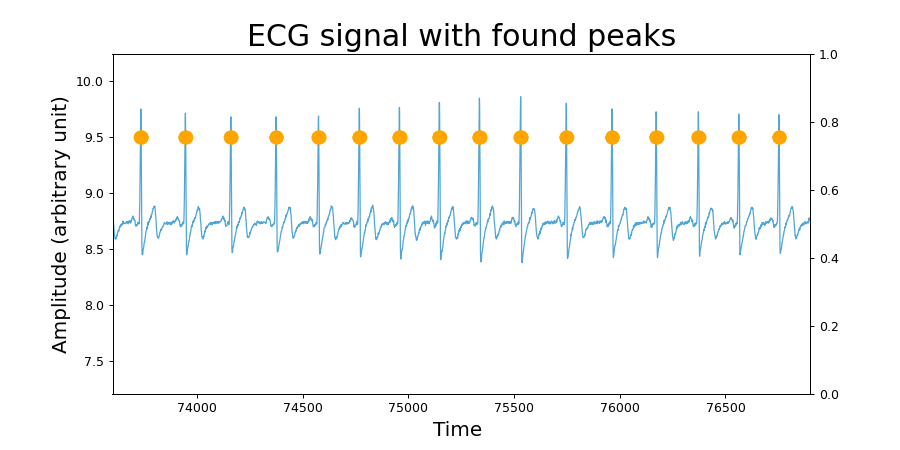

<IPython.core.display.Javascript object>


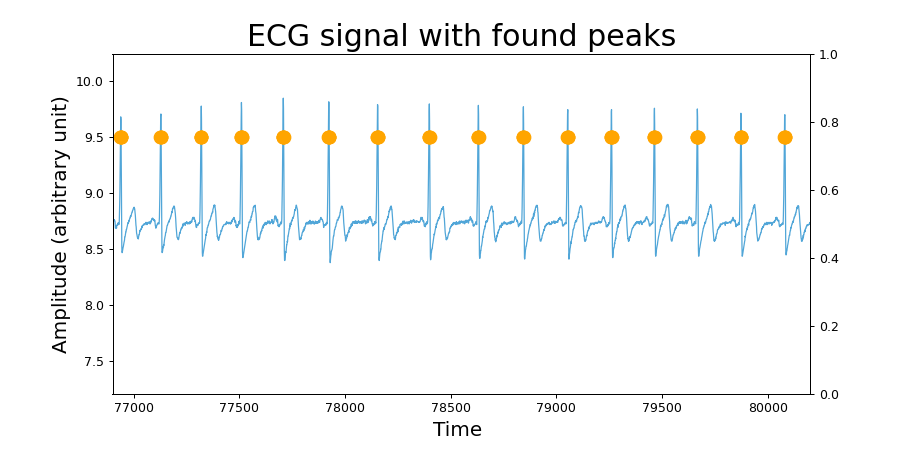

<IPython.core.display.Javascript object>


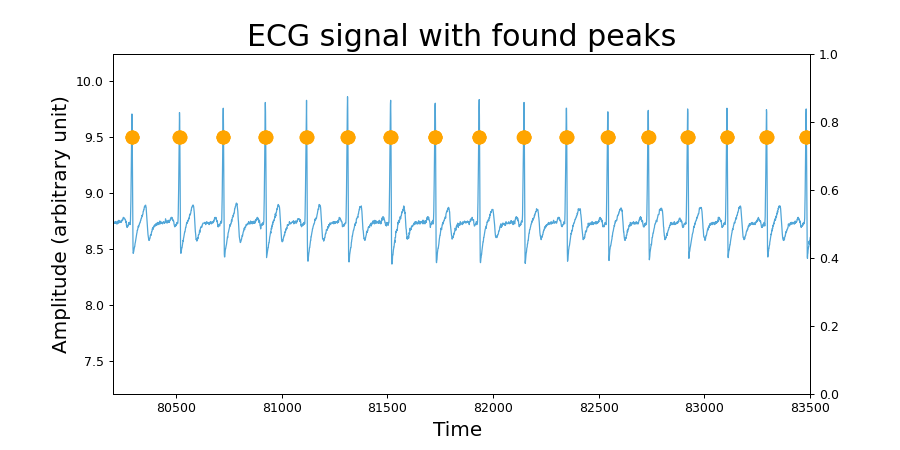

<IPython.core.display.Javascript object>


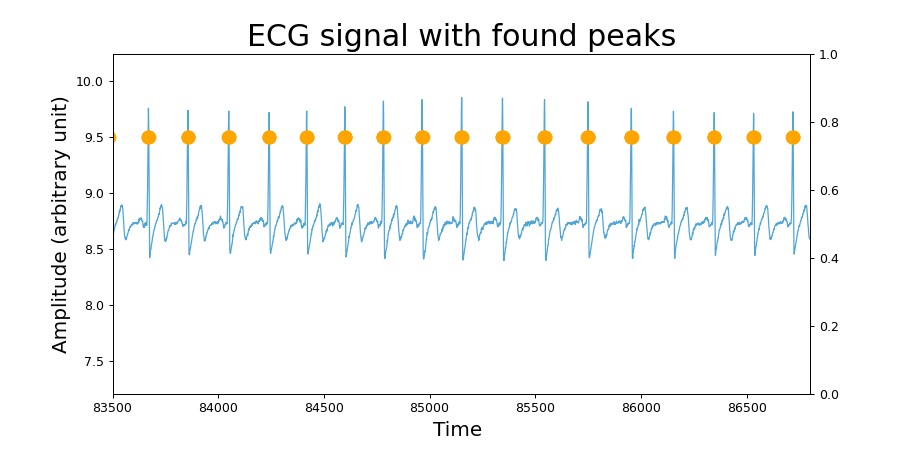

<IPython.core.display.Javascript object>


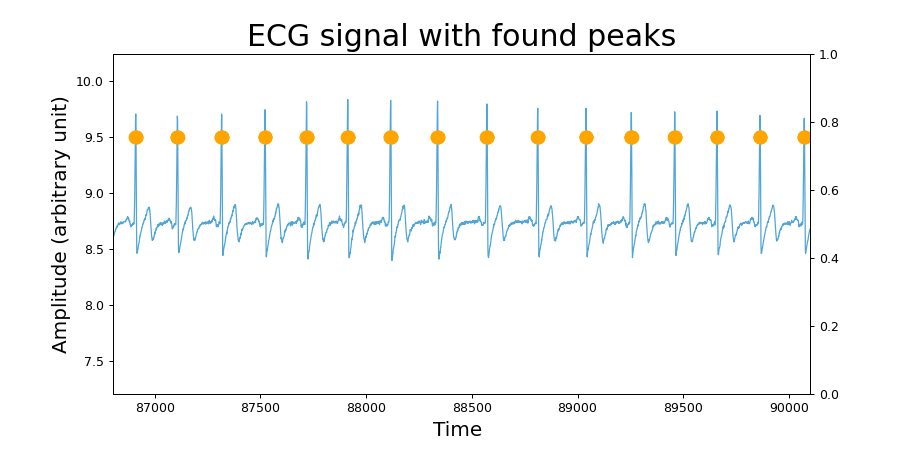

<IPython.core.display.Javascript object>


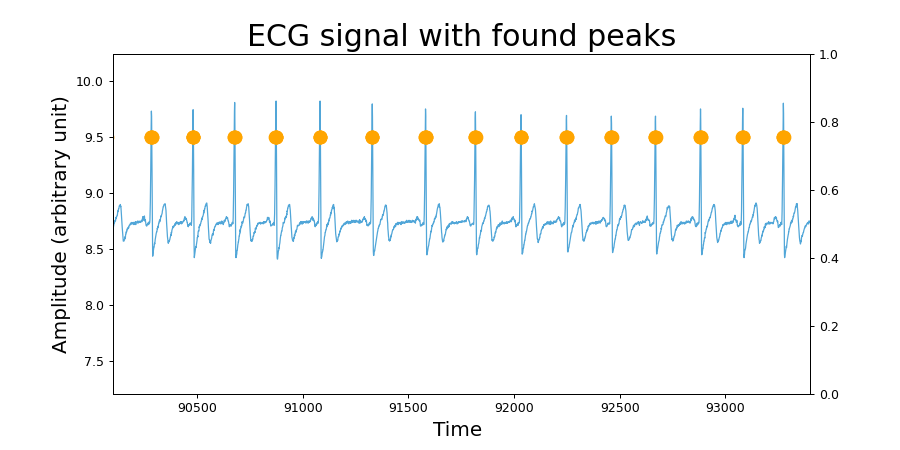

<IPython.core.display.Javascript object>


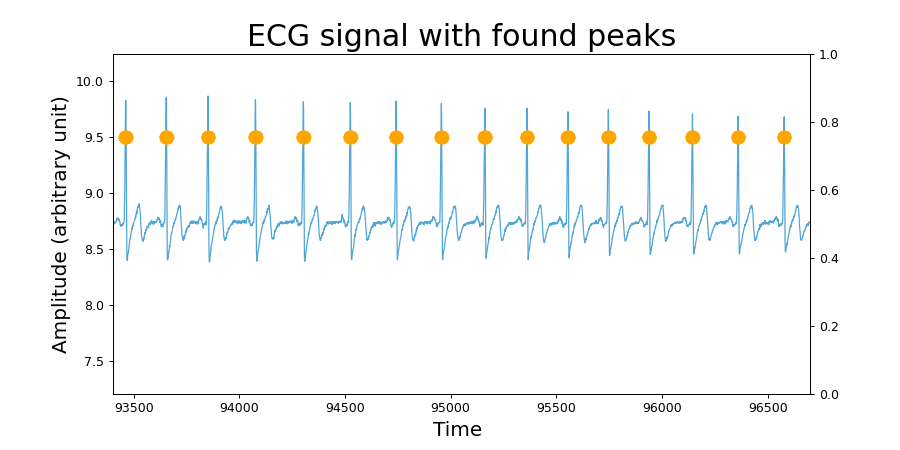

<IPython.core.display.Javascript object>


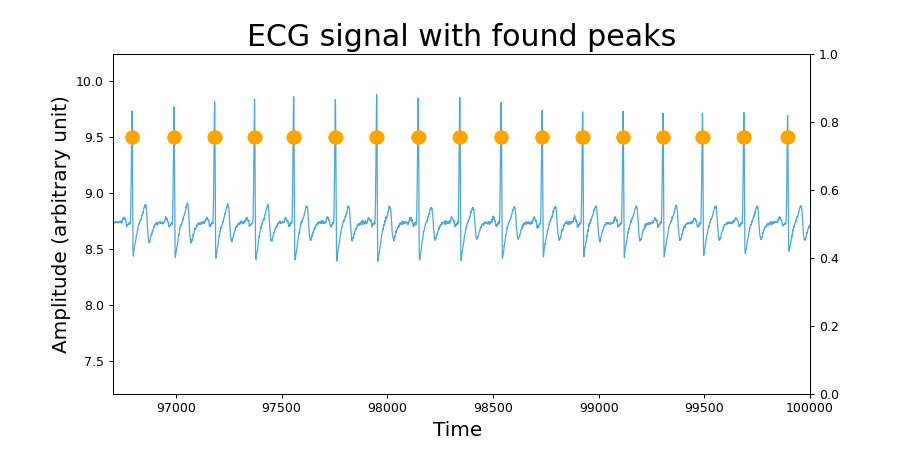

In [302]:
sampfrom = 1000
sampto = 100000
nr_plots = 30

ecg_slice = ecg['ECG'][sampfrom:sampto]
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.5)
    
    # plot similarity
    plt.figure(figsize=(10, 5))
    plt.title("ECG signal with found peaks", fontsize=24)
    plt.plot(ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(9.5, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
    plt.xlabel("Time ", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    
    ax2 = plt.gca().twinx()
    #ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    ax2.set_xlim(start, stop)
    #ax2.set_ylim(-2000, 2000)
    #ax2.legend(loc="upper right", fontsize=20)

In [291]:
print(peaks[25:50])

Int64Index([1633, 1755, 1756, 1757, 1758, 1759, 1760, 1884, 1885, 1886, 1887,
            1888, 2013, 2014, 2015, 2016, 2017, 2143, 2144, 2145, 2146, 2147,
            2271, 2272, 2273],
           dtype='int64')


## Data synchronization 

In [160]:
def sync_offset(t0_ecg, ecg, bvp):
    t1_ecg = ecg['Timestamp'].iat[-1]
    t1_bvp = bvp['Timestamp'].iat[-1]
    t0_bvp = bvp['Timestamp'][0]

    if t0_ecg < t0_bvp and t1_ecg < t1_bvp:
        
        t0_loc = ecg.loc[bvp['Timestamp'] == round(t0_bvp, 2)]
        t1_loc = bvp.loc[bvp['Timestamp'] == round(t1_ecg, 2)]
        offset_bvp = bvp.truncate(before = t0_bvp, after = t1_loc.index[0])
        offset_ecg = ecg.truncate(before = t0_loc, after = t1_ecg)
        
    elif t0_ecg > t0_bvp and t1_ecg > t1_bvp:
        
        t0_loc = bvp.loc[bvp['Timestamp'] == round(t0_ecg, 2)]
        t1_loc = ecg.loc[bvp['Timestamp'] == round(t1_ecg, 2)]
        offset_bvp = bvp.truncate(before = t0_loc.index[0], after = t1_bvp)
        offset_ecg = ecg.truncate(before = t0_ecg, after = t1_loc)
        
    elif t0_ecg < t0_bvp and t1_ecg > t1_bvp:
        
        t0_loc = ecg.loc[ecg['Timestamp'] == round(t0_bvp, 2)]
        t1_loc = ecg.loc[ecg['Timestamp'] == round(t1_bvp, 2)]
        offset_bvp = bvp
        offset_ecg = ecg.truncate(before = t0_loc, after = t1_ecg)
    
    elif t0_ecg > t0_bvp and t1_ecg < t1_bvp:
        
        t0_loc = bvp.loc[bvp['Timestamp'] == round(t0_ecg, 2)]
        t1_loc = bvp.loc[bvp['Timestamp'] == round(t1_ecg, 2)]
        offset_bvp = bvp.truncate(before = t0_loc.index[0], after = t1_loc.index[0])
        offset_ecg = ecg
    
    return offset_ecg, offset_bvp

In [255]:
offset_ecg, offset_bvp = sync_offset(t0_ecg, ecg, bvp_p14)

In [162]:
offset_ecg

Timestamp   ECG  Second
0      1655765484.86 12.67    0.00
1      1655765484.86 18.94    0.00
2      1655765484.86 20.95    0.01
3      1655765484.87 21.24    0.01
4      1655765484.87 20.81    0.02
...              ...   ...     ...
203211 1655766278.65  8.50  793.79
203212 1655766278.65  8.50  793.80
203213 1655766278.66  8.50  793.80
203214 1655766278.66  8.51  793.80
203215 1655766278.66  8.50  793.81

[203216 rows x 3 columns]

In [163]:
ecg

Timestamp   ECG  Second
0      1655765484.86 12.67    0.00
1      1655765484.86 18.94    0.00
2      1655765484.86 20.95    0.01
3      1655765484.87 21.24    0.01
4      1655765484.87 20.81    0.02
...              ...   ...     ...
203211 1655766278.65  8.50  793.79
203212 1655766278.65  8.50  793.80
203213 1655766278.66  8.50  793.80
203214 1655766278.66  8.51  793.80
203215 1655766278.66  8.50  793.81

[203216 rows x 3 columns]

In [164]:
offset_bvp

Timestamp    BVP  Second
27063 1655765484.86 -17.47  422.86
27064 1655765484.88  -8.32  422.88
27065 1655765484.89   4.97  422.89
27066 1655765484.91  19.03  422.91
27067 1655765484.92  30.45  422.92
...             ...    ...     ...
77862 1655766278.59  -4.90 1216.59
77863 1655766278.61  -1.96 1216.61
77864 1655766278.62   2.16 1216.62
77865 1655766278.64   7.48 1216.64
77866 1655766278.66  12.98 1216.66

[50804 rows x 3 columns]

In [165]:
bvp_p14

Timestamp   BVP  Second
0     1655765062.00 -0.00    0.00
1     1655765062.02 -0.00    0.02
2     1655765062.03 -0.00    0.03
3     1655765062.05 -0.00    0.05
4     1655765062.06 -0.00    0.06
...             ...   ...     ...
85289 1655766394.64 21.55 1332.64
85290 1655766394.66 17.78 1332.66
85291 1655766394.67 14.26 1332.67
85292 1655766394.69 10.98 1332.69
85293 1655766394.70  7.93 1332.70

[85294 rows x 3 columns]

## Downsampling ECG signal

In [177]:
offset_ecg

Timestamp   ECG  Second
0      1655765484.86 12.67    0.00
1      1655765484.86 18.94    0.00
2      1655765484.86 20.95    0.01
3      1655765484.87 21.24    0.01
4      1655765484.87 20.81    0.02
...              ...   ...     ...
203211 1655766278.65  8.50  793.79
203212 1655766278.65  8.50  793.80
203213 1655766278.66  8.50  793.80
203214 1655766278.66  8.51  793.80
203215 1655766278.66  8.50  793.81

[203216 rows x 3 columns]

In [256]:
secs = len(offset_ecg['ECG'])/256.0 # Number of seconds in signal X
samps = secs*64     # Number of samples to downsample
f = signal.resample(offset_ecg['ECG'], int(samps))

In [258]:
f-8.7

array([ 5.19466613, 12.79620951,  8.76045934, ..., -0.6523899 ,
        0.40148145, -1.25628254])

<IPython.core.display.Javascript object>


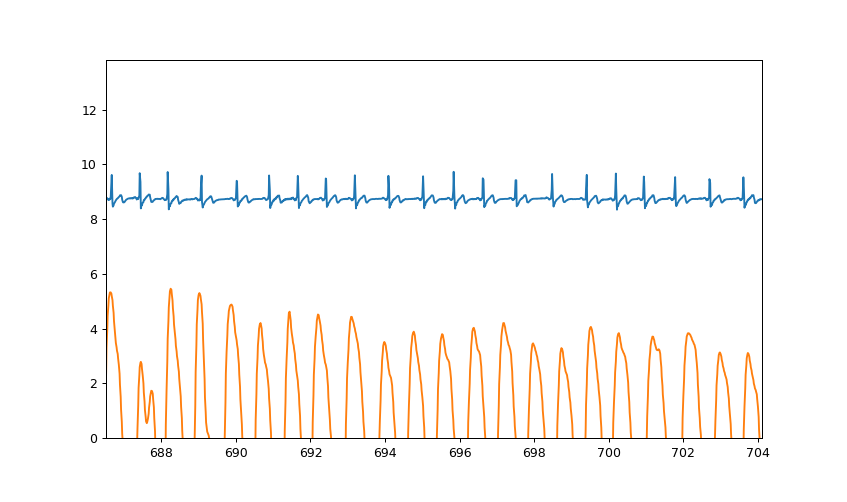

In [259]:
plt.plot(offset_bvp['Second'], f)
plt.plot(offset_bvp['Second'], offset_bvp['BVP']/10)

In [219]:
corr = signal.correlate(f, offset_bvp['BVP'])

[13.89466613 21.49620951 17.46045934 ...  8.0476101   9.10148145
  7.44371746]


Timestamp    BVP  Second
27063 1655765484.86 -17.47  422.86
27064 1655765484.88  -8.32  422.88
27065 1655765484.89   4.97  422.89
27066 1655765484.91  19.03  422.91
27067 1655765484.92  30.45  422.92
...             ...    ...     ...
77862 1655766278.59  -4.90 1216.59
77863 1655766278.61  -1.96 1216.61
77864 1655766278.62   2.16 1216.62
77865 1655766278.64   7.48 1216.64
77866 1655766278.66  12.98 1216.66

[50804 rows x 3 columns]